# CNF 


Set to true if the notebook is on google colab

In [1]:
colab_notebook = False

### Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
if colab_notebook:
    %pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import ImageFolder
import os, glob, random, shutil
from PIL import Image
import math
from torch.utils.data import Subset
from tqdm.auto import tqdm
import torch.optim as optim
import os
import numpy as np
from torchdiffeq import odeint_adjoint as odeint
import torchvision.transforms as transforms

In [3]:
if colab_notebook:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    dstn = "/content/drive" # location of where to save the data
else:
    dstn = os.path.join(os.getcwd(), 'data')

## 

### Resize and preprocess all images, define dataloader (batch size is used in the Monte Carlo estimate for the mean in the loss function)

C:\Users\eman0293\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


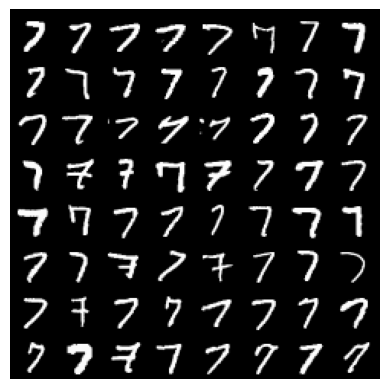

Batch shape: torch.Size([64, 1, 28, 28]) | unique labels: [7]
In total there are 640 images


In [4]:
bs = 64 # batch size

MNIST_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_ds = datasets.MNIST(dstn, train=True,  download=True, transform=MNIST_tf)
test_ds  = datasets.MNIST(dstn, train=False, download=True, transform=MNIST_tf)

def only_digit_subset(ds, digit=1):
    """
    Keep only one class (digit) of the MNIST dataset
    """
    targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
    idx = (targets == digit).nonzero(as_tuple=True)[0]
    return Subset(ds, idx)

n = 600 # None # number of images to keep
digit = 7
subset_train_ds = only_digit_subset(train_ds, digit)
if n is not None:
    subset_train_ds = Subset(subset_train_ds, range(n))

train_loader_MNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
test_loader_MNIST = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

imgs, labels = next(iter(train_loader_MNIST))
grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1, 1))
plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(-1), cmap="gray") # resize the image to make it of size (B, Channels, Height, Width)
plt.axis("off"); plt.show()
print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

print(f"In total there are {len(train_loader_MNIST)*bs} images")


class kept: Bag (index 8)
Batch shape: torch.Size([32, 1, 28, 28]) | unique labels: [8]


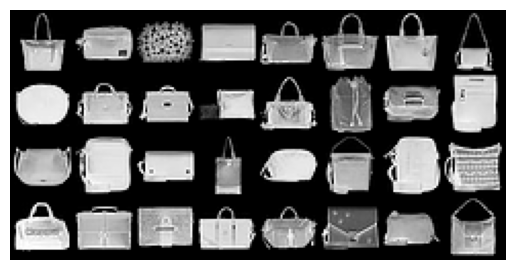

In total there are 608 images


In [5]:
bs = 32

fMNIST_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.FashionMNIST(dstn, train=True,  download=True, transform=fMNIST_tf)
test_ds  = datasets.FashionMNIST(dstn, train=False, download=True, transform=fMNIST_tf)

fashion_classes = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]
def class_subset(ds, target):
    """
    Keep only one class
    """
    targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
    if isinstance(target, str):
        cls_idx = fashion_classes.index(target)
    else:
        cls_idx = int(target)
    idx = (targets == cls_idx).nonzero(as_tuple=True)[0]
    return Subset(ds, idx), cls_idx

n = 600 #None
target_class = "Bag"
subset_train_ds, cls_idx = class_subset(train_ds, target_class)
if n is not None:
    train_one = Subset(subset_train_ds, range(n))

#train_loader_fMNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
train_loader_fMNIST = DataLoader(train_one, batch_size=bs, shuffle=True, num_workers=0, pin_memory=False)

test_loader_fMNIST  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

imgs, labels = next(iter(train_loader_fMNIST))
print(f"class kept: {fashion_classes[cls_idx]} (index {cls_idx})")
print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1,1))
plt.imshow(grid.permute(1,2,0).cpu().squeeze(-1), cmap="gray")
plt.axis("off"); plt.show()

print(f"In total there are {len(train_loader_fMNIST)*bs} images")

In [6]:
data_identifier = 'MNIST'
#data_identifier = 'FashionMNIST'

if data_identifier == 'FashionMNIST':
    train_loader = train_loader_fMNIST
if data_identifier == 'MNIST':
    train_loader = train_loader_MNIST

## Defining a simple network

In [7]:
# The RHS of the ODE du/dt=f(u(t)):
class RHSFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, 128)
        self.fc2 = nn.Linear(128,dim)
        self.tanh = nn.Tanh()

    def forward(self, t, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x


# The ODE, i.e., CNF model:
class CNFModel(nn.Module):
    def __init__(self, dim, T=1):
        super().__init__()
        self.T = T
        self.dim = dim
        self.f = RHSFunc(dim)
        self.base_dist = torch.distributions.Normal(torch.zeros(dim), torch.ones(dim)) # Normal distribution with mean 0 and std 1
        self.integration_time = torch.tensor([T, 0]).float()
        
    def forward(self, x):
        """
        The model takes a batch x of our data. x has some distribution that we
        would like to learn. Below, x is transformed into z0, which is a sample
        of our base distribution N(0,1). We integrate backwards since z0 is a
        sample in the "original" distribution.
        Note that df/dz0 is set to zero, so the RHS of eq. (6) in 
        https://arxiv.org/pdf/1806.07366 becocomes log(p(x))=log(p(z0)), meaning
        that the model is not accounting for the volume change in the likelihood
        computation. While this is not entirely accurate, the network is still 
        learning a vector field f describing where samples z0 in the latent 
        space end up, yielding positive results in the end.
        """
        z0 = odeint(self.f, x, self.integration_time)[-1] # Integrating over f from 1 to 0
        return z0

    def log_prob(self, x):
        z0 = self.forward(x)
        return self.base_dist.log_prob(z0).sum(dim=1)


## Training and saving

In [ ]:
#%% Training


# Hyper parameters
num_epochs = 100
batch_size = bs
learning_rate = 1e-3
subset_size = 500 

device = "cuda" if torch.cuda.is_available() else "cpu"

dim = 28*28
model = CNFModel(dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



if data_identifier == 'FashionMNIST':
    save_path = f"training_results_fMNIST_{target_class}.pth"
if data_identifier == 'MNIST':
    save_path = f"training_results_MNIST_{digit}.pth"


if os.path.exists(save_path):
    print(f"A previous version of {save_path} already exists.")
    print("Pick an option:")
    print("1. Train and overwrite training_results.pth")
    print("2. Train without saving")
    print("3. Don't run the code")
    if data_identifier == 'FashionMNIST':
        print("4. Train and save with a new filename (training_results_fMNIST_vX.pth)")
    if data_identifier == 'MNIST':
        print("4. Train and save with a new filename (training_results_MNIST_vX.pth)")


    choice = input("Enter 1, 2, 3, or 4: ")

    if choice == "1":
        save_results = True
        save_path_final = save_path
    elif choice == "2":
        save_results = False
        save_path_final = None
    elif choice == "3":
        print("Exiting without training.")
        exit()
    elif choice == "4":
        base, ext = os.path.splitext(save_path)
        version = 2
        save_path_final = f"{base}_v{version}{ext}"
        while os.path.exists(save_path_final):
            version += 1
            save_path_final = f"{base}_v{version}{ext}"
        save_results = True
        print(f"Results will be saved to {save_path_final}")
    else:
        print("Invalid choice. Exiting.")
        exit()
else:
    save_results = True
    save_path_final = save_path





saved_models = []   # will hold (epoch, model_state_dict)
losses = [] 

for epoch in range(num_epochs):
    for batch, _ in train_loader:
        batch = batch.view(batch.size(0), -1).to(device) # Flattens each image from shape (1, 28, 28) to (784).
        loss = -model.log_prob(batch).mean() # Negative log likelihood. The lower, the higher the likelihood that we have the "correct" distribution.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    losses.append((epoch+1, loss.item()))
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    
    saved_models.append((epoch+1, model.state_dict()))


if save_results:
    torch.save({
        "losses": losses,
        "saved_models": saved_models
    }, save_path_final)
    print(f"Results saved to {save_path_final}")
else:
    print("Training complete, but results were not saved.")

Epoch 1, Loss: 844.6136
Epoch 2, Loss: 797.8185
Epoch 3, Loss: 776.3305
Epoch 4, Loss: 771.7731
Epoch 5, Loss: 770.1702
